In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.io as pio
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn



def rand_jitter(arr, intensity = .01):
    stdev = intensity*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [3]:
ntube = pd.read_csv('/Users/Ben/Dropbox/Insight/noisetube-scrape/noise-tube-boxed.csv')
ntube = ntube.drop('city', axis = 1)
ntube = ntube.rename(index = str, columns = {'loudness': 'db'})
# noise tube records for about 3 seconds per measurement
ntube = ntube.assign(dur = lambda x: x.n_agg * 3)
nscore = pd.read_csv('/Users/Ben/Dropbox/Insight/noisescore/noise-score-boxed.csv')
nscore = nscore.rename(index = str, columns = {'decibelMean': 'db'})
# noise score records for about 10s per measurement
nscore['dur'] = 10

noise = pd.concat([ntube, nscore])
noise = noise.drop('Unnamed: 0', axis = 1)

# extract day of the week
def wkday_conv(day):
    '''
    takes an integer from 0 to 6.
    if 0 - 4, then wkday = 1
    if 5 or 6, then wkday = 0
    '''
    if day < 5:
        wkday = 1
    else:
        wkday = 0
    return wkday

noise['wkday'] = [wkday_conv(day) for day in noise.day]

In [37]:
# average measurement represents about 3 minutes of noise levels
np.mean(noise.dur) / 60

2.987851037851038

Text(0, 0.5, 'Latitude')

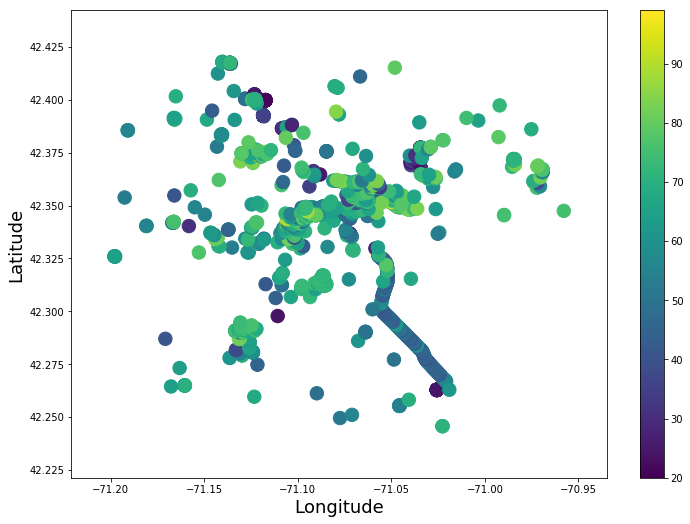

In [4]:
plt.figure(figsize = (12., 8.6))
plt.scatter(noise.lng, noise.lat, s = 180, c = noise.db)
plt.colorbar(); plt.xlabel('Longitude', fontsize=18); plt.ylabel('Latitude', fontsize=18)

In [50]:
mapbox_access_token = 'pk.eyJ1IjoiYmVuc2h1bG1hbiIsImEiOiJjand2ZnUxYmUwN3JkNDlsZmE1ajFiMXI0In0.y4SeH8uf0OUZzDmssIa3Fw'
plotly.tools.set_credentials_file(username='benshulman', api_key='n3APnw9QVFL8Rljv02qk')

data = [
    go.Scattermapbox(
        lat = list(noise.lat),
        lon = list(noise.lng),
        mode='markers',
        hoverinfo = 'text',
        text = noise.db.round(decimals = 0),
        marker = go.scattermapbox.Marker(
            size = 20,
            opacity = 0.5
        )
    )
]

layout = go.Layout(
    width = 800,
    height = 800,
    autosize=True,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat = 42.3665,
            lon = -71.079
        ),
        pitch = 0,
        zoom = 11
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='noise-obs')

In [42]:
map = folium.Map(
    location = [42.3601, -71.0589],
    zoom_start = 12
) 

# Plot it on the map
HeatMap(noise[['lat', 'lng']]).add_to(map)
# Display the map
map

In [29]:
noise_wkday = noise[noise.wkday == 1]
len(noise_wkday)

1487

In [30]:
noise_wkend = noise[noise.wkday == 0]
len(noise_wkend)

424

In [31]:
noise.hour.value_counts()

3     206
12    200
9     161
11    116
10     97
13     89
4      84
5      81
6      76
0      74
2      71
8      66
23     66
7      63
1      60
19     54
16     52
18     50
20     49
21     49
15     46
17     35
14     33
22     33
Name: hour, dtype: int64

In [32]:
def hour_bucket(hour):
    hour_dict = {
    0: '12 am - 2 am',
    1: '12 am - 2 am',
    2: '12 am - 2 am',
    3: '3 am - 7 am',
    4: '3 am - 7 am',
    5: '3 am - 7 am',
    6: '3 am - 7 am',
    7: '3 am - 7 am',
    8: '8 am - 10 am',
    9: '8 am - 10 am',
    10: '8 am - 10 am',
    11: '11 am - 1 pm',
    12: '11 am - 1 pm',
    13: '11 am - 1 pm',
    14: '2 pm - 4 pm',
    15: '2 pm - 4 pm',
    16: '2 pm - 4 pm',
    17: '5 pm - 8 pm',
    18: '5 pm - 8 pm',
    19: '5 pm - 8 pm',
    20: '5 pm - 8 pm',
    21: '9 pm - 11 pm',
    22: '9 pm - 11 pm',
    23: '9 pm - 11 pm'
    }
    hour_out = hour_dict[hour]
    return hour_out

hr_bkt_order = [
'12 am - 2 am',
'3 am - 7 am',
'8 am - 10 am',
'11 am - 1 pm',
'2 pm - 4 pm',
'5 pm - 8 pm',
'9 pm - 11 pm'
]

noise = noise.assign(hr_bkt = lambda x: [hour_bucket(hour) for hour in noise.hour])
noise_wkday = noise_wkday.assign(hr_bkt = lambda x: [hour_bucket(hour) for hour in noise_wkday.hour])
noise_wkend = noise_wkend.assign(hr_bkt = lambda x: [hour_bucket(hour) for hour in noise_wkend.hour])

In [90]:
hour_bucket(14)

'2 pm - 4 pm'

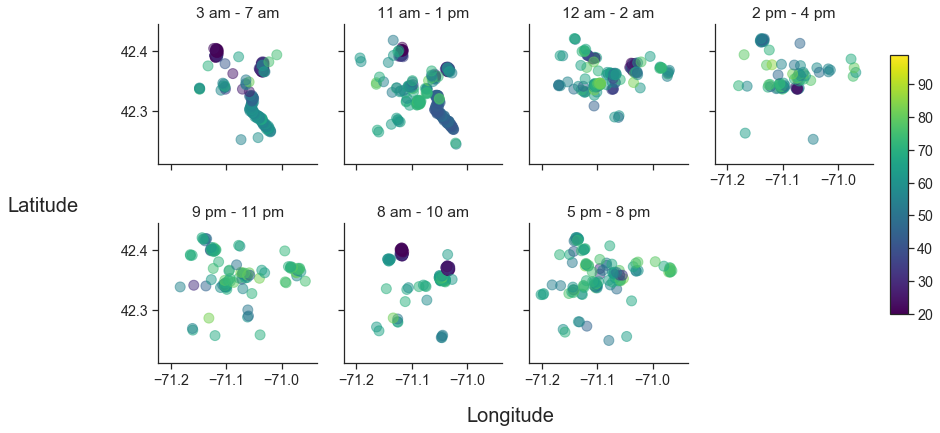

In [37]:
# code adapted from https://stackoverflow.com/a/44642014/3055434

sns.set(font_scale = 1.3)
sns.set_style("ticks")

g = sns.FacetGrid(noise_wkday, col = 'hr_bkt', col_wrap = 4)

def facet_scatter(x, y, c, **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    kwargs.pop("color")
    plt.scatter(rand_jitter(x), rand_jitter(y), c=c, **kwargs)

vmin, vmax = np.min(noise_wkday.db), np.max(noise_wkday.db)
cmap = sns.diverging_palette(240, 10, l=65, center="dark", as_cmap=True)

g = g.map(facet_scatter, 'lng', 'lat', "db",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax, cmap='viridis')

#this surpresses the x- and y-labels on each axes of the bottom/leftmost column
g.set_axis_labels('', '') 

# overall ylabel
g.fig.text(x = 0, y = 0.5, 
           verticalalignment='center', #make sure it's aligned at center vertically
           horizontalalignment = 'right',
           s = 'Latitude', #this is the text in the ylabel
           size = 20,
           rotation=0) #vertical text

#overall xlabel
g.fig.text(x=0.5, y=0, 
           horizontalalignment='center', #make sure it's aligned at center horizontally
           size = 20,
           s='Longitude' #this is the text in the xlabel
        )

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax, cmap='viridis')

# Draw the colorbar
g.fig.colorbar(points, cax=cax)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

plt.savefig('/Users/Ben/Dropbox/Insight/slide-figures/noise-hr-wkday.png', dpi=300, bbox_inches='tight')

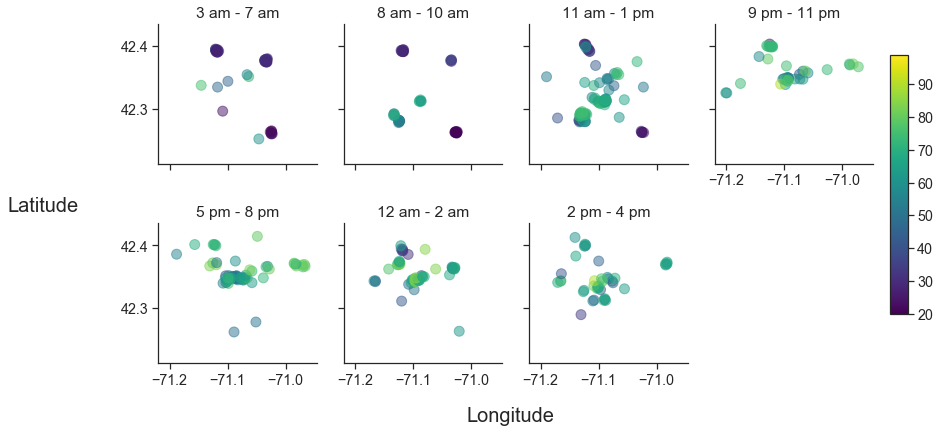

In [38]:
# code adapted from https://stackoverflow.com/a/44642014/3055434

sns.set(font_scale = 1.3)
sns.set_style("ticks")

g = sns.FacetGrid(noise_wkend, col = 'hr_bkt', col_wrap = 4)

def facet_scatter(x, y, c, **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    kwargs.pop("color")
    plt.scatter(rand_jitter(x), rand_jitter(y), c=c, **kwargs)

vmin, vmax = np.min(noise_wkday.db), np.max(noise_wkday.db)
cmap = sns.diverging_palette(240, 10, l=65, center="dark", as_cmap=True)

g = g.map(facet_scatter, 'lng', 'lat', "db",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax, cmap='viridis')

#this surpresses the x- and y-labels on each axes of the bottom/leftmost column
g.set_axis_labels('', '') 

# overall ylabel
g.fig.text(x = 0, y = 0.5, 
           verticalalignment='center', #make sure it's aligned at center vertically
           horizontalalignment = 'right',
           s = 'Latitude', #this is the text in the ylabel
           size = 20,
           rotation=0) #vertical text

#overall xlabel
g.fig.text(x=0.5, y=0, 
           horizontalalignment='center', #make sure it's aligned at center horizontally
           size = 20,
           s='Longitude' #this is the text in the xlabel
        )

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax, cmap='viridis')

# Draw the colorbar
g.fig.colorbar(points, cax=cax)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

plt.savefig('/Users/Ben/Dropbox/Insight/slide-figures/noise-hr-wkend.png', dpi=300, bbox_inches='tight')

In [4]:
rest_bar = pd.read_csv('/Users/Ben/Dropbox/Insight/data-merge/merge-aws/x-in/point_latlng_clean/bars-rests-combined.csv')

In [5]:
mapbox_access_token = 'pk.eyJ1IjoiYmVuc2h1bG1hbiIsImEiOiJjand2ZnUxYmUwN3JkNDlsZmE1ajFiMXI0In0.y4SeH8uf0OUZzDmssIa3Fw'
plotly.tools.set_credentials_file(username='benshulman', api_key='n3APnw9QVFL8Rljv02qk')

data = [
    go.Scattermapbox(
        lat = list(noise.lat),
        lon = list(noise.lng),
        mode='markers',
        hoverinfo = 'text',
        text = noise.db.round(decimals = 0),
        marker = go.scattermapbox.Marker(
            size = 20,
            opacity = 0.5
        )
    ),
    go.Scattermapbox(
        lat = list(rest_bar.lat),
        lon = list(rest_bar.lng),
        mode='markers',
        hoverinfo = 'text',
        marker = go.scattermapbox.Marker(
            size = 20,
            opacity = 0.5,
            color = 'green'
        )
    )
]

layout = go.Layout(
    width = 800,
    height = 800,
    autosize=True,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat = 42.3665,
            lon = -71.079
        ),
        pitch = 0,
        zoom = 11
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='noise-rest_bar-obs.png')

In [119]:
mapbox_access_token = 'pk.eyJ1IjoiYmVuc2h1bG1hbiIsImEiOiJjand2ZnUxYmUwN3JkNDlsZmE1ajFiMXI0In0.y4SeH8uf0OUZzDmssIa3Fw'
plotly.tools.set_credentials_file(username='benshulman', api_key='n3APnw9QVFL8Rljv02qk')

data = [
    go.Scattermapbox(
        lat = list(rest_bar.lat),
        lon = list(rest_bar.lng),
        mode='markers',
        hoverinfo = 'text',
        marker = go.scattermapbox.Marker(
            size = 20,
            opacity = 0.5,
            color = 'green'
        )
    )
]

layout = go.Layout(
    width = 800,
    height = 800,
    autosize=True,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat = 42.3665,
            lon = -71.079
        ),
        pitch = 0,
        zoom = 11
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='rest_bar-obs.png')

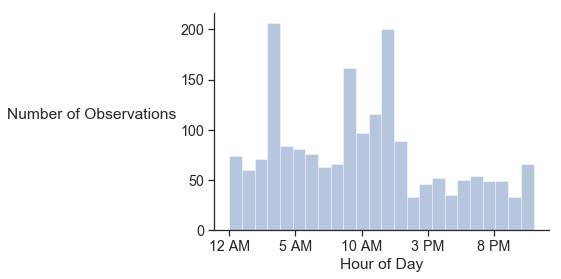

In [24]:
plt.figure(figsize=(6,4))
sns.set(font_scale = 1.3)
sns.set_style("ticks")
hour_dist = sns.distplot(noise.hour,  bins = 24, kde = False)
hour_dist.set(xlabel = 'Hour of Day')
hour_dist.set_ylabel('Number of Observations', rotation = 0, ha = 'right')
hour_dist.set(xticklabels=[
    '',
    '12 AM',
    '5 AM',
    '10 AM',
    '3 PM',
    '8 PM'
])
sns.despine()
plt.savefig('/Users/Ben/Dropbox/Insight/slide-figures/hour_dist.png', dpi=300, bbox_inches='tight')